# Image with Mask Preparation for "ReLU me!" Experiment

In this notebook we:
1. Load an image
2. Convert the pixels to 1D format

    This steps starts from an image as a 3D array (width, height, channels).
    It outputs a target array (width\*height, channels) and a source array (width\*height, 2).
    The source array contain the x,y location of the pixel and the target array contains the pixel RGB values at that location.
3. Normalize the x,y locations to lie in the -1, 1 range.
4. Normalize the pixels to lie in the 0-1 range
5. Save the results to disk

In [4]:
import os
import json
import utils
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

plt.style.use('dark_background')

Notebook parameters

In [5]:
image_path = 'data/cat-attack.jpeg'
mask_path = 'data/cat-attack-mask.jpg'
# colormode can be either 'grayscale' or 'rgb'
color_mode = 'grayscale'
resize_factor = 1/5
# defines pixel value to loss weight mapping
weight_0 = 0.1
weight_255 = 1
out_folder = 'cat-attack-masked-medium-gray'

## Loading image

In [6]:
# load the image a first time to get the original size
img = image.load_img(image_path, color_mode=color_mode)
original_size = image.img_to_array(img).shape

In [7]:
# compute the dimension of the resized image
target_size = int(original_size[0]*resize_factor), int(original_size[1]*resize_factor)
height, width = target_size
n_pixels = height * width
n_channels = original_size[2]
print("Original size:", original_size[:2])
print("Size of resized image:", target_size)

# reload the image with the right dimensions
img = image.load_img(
    image_path, color_mode=color_mode, target_size=target_size,
    interpolation='bilinear')
# similarly for mask
mask = image.load_img(
    mask_path, color_mode='grayscale', target_size=target_size,
    interpolation='bilinear')

Original size: (1024, 768)
Size of resized image: (204, 153)


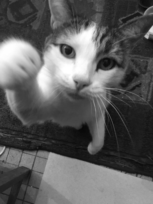

In [8]:
img

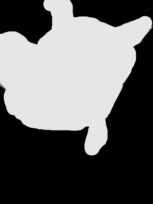

In [9]:
mask

## Process image

We assume the mask is given by an image with pixel intensity values between 0 and 255.
We would like to **re-normalize the mask** to lie between 0 and 1 which is the weight of the loss for this pixel.
In particular in the ouput mask a weight of 0 will mean that the pixel will be ignored.
The user can give 2 values, $w_0, w_{255}$, which gives the **weights** that should be **attributed to pixel values of 0 and 255** respectively.
For pixel values in between, they are linearly interpolated.

Bellow, the formula that gives the loss weight $w$ in function of the pixel value $p$:
$$w = w_0 + {p \over 255}(w_{255} - w_0)$$

In [10]:
# transform the image to long format
pic = image.img_to_array(img)
pix_loc_long, pic_long = utils.pic_to_long(pic)

# similarly for mask
mask_pic = image.img_to_array(mask)
_, mask_long = utils.pic_to_long(mask_pic)
# convert to weight values
weight_long = weight_0 + mask_long*(weight_255-weight_0)/255

In [11]:
# compute the average color of the image
av_color = np.mean(pic_long, axis=0)
# remove the average color and divide by 255
pic_long_norm = (pic_long - av_color[np.newaxis, :])/255

In [12]:
# normalize pixel coordinate tensor
pix_loc_long_norm = pix_loc_long / np.array([[height, width]])

## Writing to disk

In [13]:
# metadata about the data preparation
metadata = {
    'image_path': image_path,
    'mask_path': mask_path,
    'original_size': original_size,
    'target_size': target_size + (n_channels,), # size of image after transformation
    'color_mode': color_mode,
    'resize_factor': resize_factor,
    'weight_0': weight_0,
    'weight_255': weight_255,
    'weight_size': target_size + (1,),
    'out_folder': out_folder,
    'av_color': av_color.tolist()
}
# create a directory for the results
os.makedirs(out_folder, exist_ok=True)
with open(out_folder+'/meta.json', 'w') as f:
    json.dump(metadata, f)
# save the image
np.savez(out_folder+'/pic_long.npz', pic_long_norm=pic_long_norm,
         pix_loc_long_norm=pix_loc_long_norm, weight_long=weight_long)